In [ ]:
# Install required libraries
!pip install Box2D
!pip install box2d-py
!pip install swig
!pip install gym==0.15.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Install dependencies to render gym environments
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
# Import required libraries
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from scipy import stats
import matplotlib.pyplot as plt
import gym
from gym import wrappers
from pyvirtualdisplay import Display

In [ ]:
# Create virtual display to render gym environments
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
# Third Party code used by authors, created by Keon: https://github.com/keon/deep-q-learning

# Agent used for defining model training steps
class Agent:
    def __init__(self,env):
        pass       
    def act(self, state):
        pass
    def update_model(self, state, action, reward, new_state, done):
        pass

In [ ]:
# Third Party code used by authors, created by Keon: https://github.com/keon/deep-q-learning

# Define DQN Model
class DQN(Agent):
    def __init__(self, env):
        # define parameters for q-network
        self.env = env
        self.replay_memory = deque(maxlen=5)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.learning_rate = 0.05
        self.target_update_counter = 0
        self.C = 8
        self.initial_random_steps = 0
        self.actions_count = 0
        self.clip_errors = True
        self.q_network = self.init_q_network()
        self.target_q_network = self.init_q_network()

    # steps used for episode start & finish
    def on_episode_start(self):
        pass
    def on_episode_end(self):
        pass

    # determine observation space and action space
    def get_observation_space(self):
        return self.env.observation_space
    def get_action_space(self):
        return self.env.action_space

    # initialise q-learning network
    def init_q_network(self):
        model = Sequential()
        state_shape = self.get_observation_space().shape
        model.add(Dense(48, input_shape=state_shape, activation="relu"))
        model.add(Dense(self.get_action_space().n, activation='linear'))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        return model

    # determine state from given state-action pair
    def act(self, state):
        self.actions_count += 1
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon or self.actions_count < self.initial_random_steps:
            return self.get_action_space().sample()
        return np.argmax(self.q_network.predict(state)[0])

    # update q-network model
    def update_model(self, state, action, reward, new_state, done):
        self.replay_memory.append([state, action, reward, new_state, done])
        self.fit_q_network()
        self.update_target_q_network()

    # sample stored episode steps in memory
    def sample_replays(self,batch_size):
        return random.choices(self.replay_memory, k=batch_size)

    # perform SGD
    def fit_q_network(self):
        batch_size = 16
        if len(self.replay_memory) < batch_size:
            return

        samples = self.sample_replays(batch_size)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_q_network.predict(state)
            predicted = self.q_network.predict(state)
            if done:
                target[0][action] = reward
            else:
                # Use Bellman equation to update target
                target[0][action] = reward + self.gamma * max(self.target_q_network.predict(new_state)[0])

                if self.clip_errors:
                    #change errors to -1, +1
                    if (target[0][action] > predicted[0][action]):
                        target[0][action] = predicted[0][action] + 1
                    elif (target[0][action] > predicted[0][action]):
                        target[0][action] = predicted[0][action] - 1
            sampled_states.append(state)
            sampled_targets.append(target)

        batched_states = np.concatenate(sampled_states,axis=0)
        batched_targets = np.concatenate(sampled_targets,axis=0)
        self.q_network.fit(batched_states, batched_targets, epochs=1, verbose=0)

    # update q-network model weights every C steps
    def update_target_q_network(self):
        self.target_update_counter += 1
        if (self.target_update_counter > self.C):
            self.target_update_counter = 0
            self.target_q_network.set_weights(self.q_network.get_weights())

In [ ]:
# Define DQL with model based exploration for Mountain Car Environment

class Model_Expl_MountainCar(DQN):
    def __init__(self, env):
        # define parameters for q-network
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.gamma = 0.99
        self.learning_rate = 0.05
        self.C = 8
        self.epsilon = 1.0
        self.env = env
        self.replay_memory = deque(maxlen=5)
        self.target_update_counter = 0
        self.initial_random_steps = 10
        self.actions_count = 0
        self.clip_errors = True
        self.q_network = self.init_q_network()
        self.target_q_network = self.init_q_network()
        self.dynamics_model = self.model()
        self.update_count = 0
        self.dynamics_model_converged = False

    # code for updating q-network model using experience replay
    def update_model(self, state, action, reward, new_state, done):
        self.replay_memory.append([state, action, reward, new_state, done])
        self.fit_q_network()
        self.update_target_q_network()
        self.update_count += 1

        if self.update_count % 25 == 0:
            self.model()
        if self.update_count % 500 == 0:
            self.eval_model()

    # determine state from given state-action pair 
    def act(self, state):
        self.actions_count += 1
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon or self.actions_count < self.initial_random_steps:
            return self.explore(state)
        return np.argmax(self.q_network.predict(state)[0])

    # perform exploration of actions
    def explore(self,state):
        if not self.dynamics_model_converged:
            return self.get_action_space().sample()
        N = len(self.replay_memory)
        no_samples = 50
        samples = []
        for i in range(N-no_samples,N):
           samples.append(self.replay_memory[i][0])
        least_p = np.inf
        best_a = -1
        for action in range(self.get_action_space().n):
            next_state = self.dynamics_model.predict(np.append(state, [[action]], axis=1))
            p = self.probability(next_state, samples)
            if p < least_p:
                best_a = action
                least_p = p
        return best_a

    # get probability for exploration
    def probability(self,state, samples):
        design = []
        for s in samples:
            design.append(s[0])
        design = np.stack(design).T
        covariance = np.cov(design)
        av = np.mean(design,axis = 1)
        p = stats.multivariate_normal.pdf(state[0],av,covariance)
        return p

    # initliaize dynamics predictor with random weights
    def model(self):
        model = Sequential()
        obs_space = (self.get_observation_space().shape[0] + 1,)
        print(obs_space)
        model.add(Dense(24, input_shape=obs_space, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.get_observation_space().shape[0], activation='linear'))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.02))
        return model

    # perform SGD on model
    def fit_model(self):
        batchsize = 64
        if len(self.replay_memory) < batchsize:
            return
        samples = self.sample_replays(batchsize)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            input_state = np.append(state, [[action]], axis=1)
            target = new_state
            sampled_states.append(input_state)
            sampled_targets.append(target)

        batched_inputs = np.concatenate(sampled_states, axis=0)
        batched_targets = np.concatenate(sampled_targets, axis=0)
        self.dynamics_model.fit(batched_inputs, batched_targets, epochs=1, verbose=0)

    # evaluate dynamics model
    def eval_model(self):
        samples = self.sample_replays(32)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            input_state = np.append(state, [[action]], axis=1)
            target = new_state
            sampled_states.append(input_state)
            sampled_targets.append(target)

        batched_inputs = np.concatenate(sampled_states, axis=0)
        batched_targets = np.concatenate(sampled_targets, axis=0)
        scores = self.dynamics_model.evaluate(batched_inputs,batched_targets,verbose=0)
        if scores < 0.005:
            self.dynamics_model_converged = True
        print(self.dynamics_model.metrics_names, scores)

In [ ]:
# Define DQL with model based exploration for Lunar Lander Environment

class Model_Expl_Lunar(DQN):
    def __init__(self, env):
        # define parameters for q-network
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9995
        self.gamma = 0.99
        self.learning_rate = 0.05
        self.C = 8
        self.epsilon = 1.0
        self.env = env
        self.replay_memory = deque(maxlen=5)
        self.target_update_counter = 0
        self.initial_random_steps = 5000
        self.actions_count = 0
        self.clip_errors = True
        self.q_network = self.init_q_network()
        self.target_q_network = self.init_q_network()
        self.dynamics_model = self.model()
        self.update_count = 0
        self.dynamics_model_converged = False

    # code for updating q-network model using experience replay
    def update_model(self, state, action, reward, new_state, done):
        self.replay_memory.append([state, action, reward, new_state, done])
        self.fit_q_network()
        self.update_target_q_network()
        self.update_count += 1

        if self.update_count % 25 == 0:
            self.model()
        if self.update_count % 500 == 0:
            self.eval_model()

    # determine state from given state-action pair 
    def act(self, state):
        self.actions_count += 1
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon or self.actions_count < self.initial_random_steps:
            return self.explore(state)
        return np.argmax(self.q_network.predict(state)[0])

    # perform exploration of actions
    def explore(self,state):
        if not self.dynamics_model_converged:
            return self.get_action_space().sample()
        N = len(self.replay_memory)
        no_samples = 50
        samples = []
        for i in range(N-no_samples,N):
           samples.append(self.replay_memory[i][0])
        least_p = np.inf
        best_a = -1
        for action in range(self.get_action_space().n):
            next_state = self.dynamics_model.predict(np.append(state, [[action]], axis=1))
            p = self.probability(next_state, samples)
            if p < least_p:
                best_a = action
                least_p = p
        return best_a

    # get probability for exploration
    def probability(self,state, samples):
        design = []
        for s in samples:
            design.append(s[0])
        design = np.stack(design).T
        covariance = np.cov(design)
        av = np.mean(design,axis = 1)
        p = stats.multivariate_normal.pdf(state[0],av,covariance)
        return p

    # initliaize dynamics predictor with random weights
    def model(self):
        model = Sequential()
        obs_space = (self.get_observation_space().shape[0] + 1,)
        print(obs_space)
        model.add(Dense(24, input_shape=obs_space, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.get_observation_space().shape[0], activation='linear'))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.02))
        return model

    # perform SGD on model
    def fit_model(self):
        batchsize = 64
        if len(self.replay_memory) < batchsize:
            return
        samples = self.sample_replays(batchsize)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            input_state = np.append(state, [[action]], axis=1)
            target = new_state
            sampled_states.append(input_state)
            sampled_targets.append(target)

        batched_inputs = np.concatenate(sampled_states, axis=0)
        batched_targets = np.concatenate(sampled_targets, axis=0)
        self.dynamics_model.fit(batched_inputs, batched_targets, epochs=1, verbose=0)

    # evaluate dynamics model
    def eval_model(self):
        samples = self.sample_replays(32)
        sampled_states = []
        sampled_targets = []
        for sample in samples:
            state, action, reward, new_state, done = sample
            input_state = np.append(state, [[action]], axis=1)
            target = new_state
            sampled_states.append(input_state)
            sampled_targets.append(target)

        batched_inputs = np.concatenate(sampled_states, axis=0)
        batched_targets = np.concatenate(sampled_targets, axis=0)
        scores = self.dynamics_model.evaluate(batched_inputs,batched_targets,verbose=0)
        if scores < 0.005:
            self.dynamics_model_converged = True
        print(self.dynamics_model.metrics_names, scores)

In [ ]:
class Plot:
  def draw_graph(env_name, model_name, tot_rewards):
      plt.plot(tot_rewards)
      plt.title(model_name + ' for '+ env_name)
      plt.xlabel('Episode')
      plt.ylabel('reward')
      plt.show()

In [ ]:
# Create Mountain Car Environment
env_mountain = gym.make("MountainCar-v0")
env_mountain.reset

# Create Lunar Lander Environment
env_lunar = gym.make("LunarLander-v2")
env_lunar.reset

<bound method TimeLimit.reset of <TimeLimit<LunarLander<LunarLander-v2>>>>

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 35ms/step
episode number: 24
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 32ms/step
episode number: 25
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 29ms/step
episode number: 26
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 25ms/step
episode number: 27
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 86ms/step
episode number: 28
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 31ms/step
episode number: 29
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 31ms/step
episode number: 30
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 45ms/step
episode number: 31
number of steps: 200, reward for episo

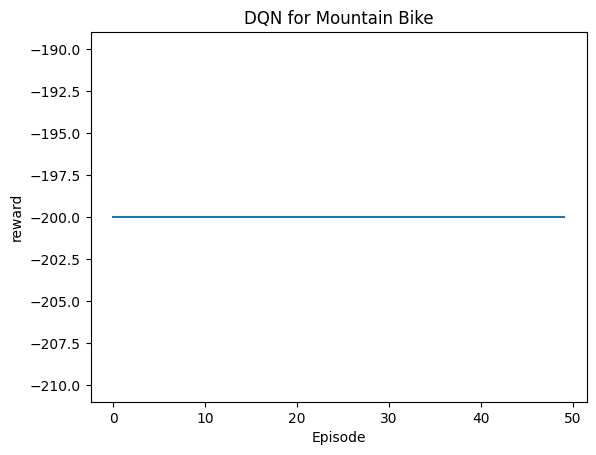

In [ ]:
# Perform DQN on Mountain Car Environment

# define/create variables for training
episodes = 50
obs_shape = (1,env_mountain.observation_space.shape[0])
model = DQN(env=env_mountain)
tot_rewards = []
ep_steps = []

# define training loop
for episode in range(episodes):
      model.on_episode_start()
      state = env_mountain.reset().reshape(obs_shape)
      step = 0
      tot_reward = 0
      done = False
      while not done:
            # commence training
            step += 1
            action = model.act(state)
            state_next, reward, done, _ = env_mountain.step(action)
            state_next = state_next.reshape(obs_shape)
            model.update_model(state, action, reward, state_next, done)
            cur_state = state_next
            tot_reward += reward
            # end training
            if done:
                break
      model.on_episode_end()

      # record reward
      tot_rewards.append(tot_reward)
      # record steps
      ep_steps.append(step)
      print(f'episode number: {episode}')
      print(f'number of steps: {step}, reward for episode: {tot_reward}')

# draw plot of results
Plot.draw_graph('Mountain Bike', 'DQN', tot_rewards)

1/1 [==============================] - 0s 71ms/step
episode number: 0
number of steps: 94, reward for episode: -460.9896206106414
1/1 [==============================] - 0s 29ms/step
episode number: 1
number of steps: 145, reward for episode: -578.0069931974265
1/1 [==============================] - 0s 25ms/step
episode number: 2
number of steps: 58, reward for episode: -151.0176778730636
1/1 [==============================] - 0s 40ms/step
episode number: 3
number of steps: 94, reward for episode: -161.38547627633707
1/1 [==============================] - 0s 40ms/step
episode number: 4
number of steps: 134, reward for episode: -337.0208744067438
1/1 [==============================] - 0s 24ms/step
episode number: 5
number of steps: 109, reward for episode: -116.39702535740423
1/1 [==============================] - 0s 26ms/step
episode number: 6
number of steps: 108, reward for episode: -231.46139376712975
1/1 [==============================] - 0s 27ms/step
episode number: 7
number of ste

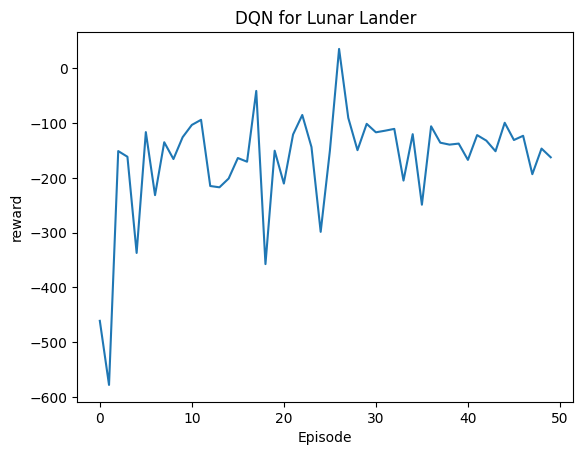

In [ ]:
# Perform DQN on Lunar Lander Environment

# define/create variables for training
episodes = 50
obs_shape = (1,env_lunar.observation_space.shape[0])
model = DQN(env=env_lunar)
tot_rewards = []
ep_steps = []

# define training loop
for episode in range(episodes):
      model.on_episode_start()
      state = env_lunar.reset().reshape(obs_shape)
      step = 0
      tot_reward = 0
      done = False
      while not done:
            # commence training
            step += 1
            action = model.act(state)
            state_next, reward, done, _ = env_lunar.step(action)
            state_next = state_next.reshape(obs_shape)
            model.update_model(state, action, reward, state_next, done)
            cur_state = state_next
            tot_reward += reward
            # end training
            if done:
                break
      model.on_episode_end()

      # record reward
      tot_rewards.append(tot_reward)
      # record steps
      ep_steps.append(step)
      print(f'episode number: {episode}')
      print(f'number of steps: {step}, reward for episode: {tot_reward}')

# draw plot of results
Plot.draw_graph('Lunar Lander', 'DQN', tot_rewards)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 28ms/step
(3,)
1/1 [==============================] - 0s 28ms/step
(3,)
1/1 [==============================] - 0s 50ms/step
(3,)
1/1 [==============================] - 0s 45ms/step
(3,)
episode number: 25
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 37ms/step
(3,)
1/1 [==============================] - 0s 28ms/step
(3,)
1/1 [==============================] - 0s 27ms/step
(3,)
1/1 [==============================] - 0s 28ms/step
(3,)
1/1 [==============================] - 0s 43ms/step
(3,)
1/1 [==============================] - 0s 35ms/step
(3,)
1/1 [==============================] - 0s 38ms/step
(3,)
1/1 [==============================] - 0s 31ms/step
(3,)
episode number: 26
number of steps: 200, reward for episode: -200.0
1/1 [==============================] - 0s 32ms/step
(3,)
1/1 [==============================] - 0s 26ms/step
(3,)
1/1 [==========

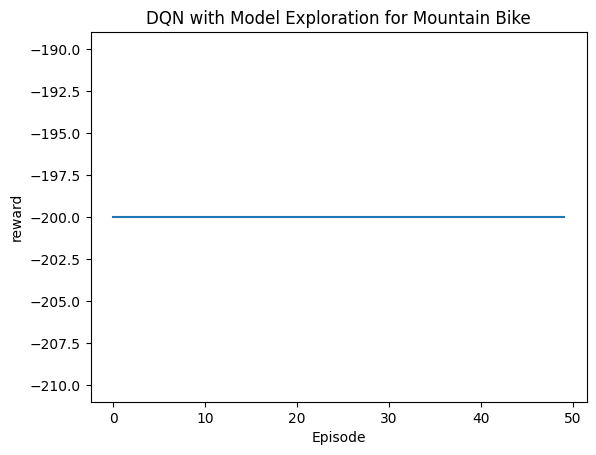

In [ ]:
# Perform DQN with Model Exploration on Mountain Car Environment

# define/create variables for training
episodes = 50
obs_shape = (1,env_mountain.observation_space.shape[0])
model = Model_Expl_MountainCar(env=env_mountain)
tot_rewards = []
ep_steps = []

# define training loop
for episode in range(episodes):
      model.on_episode_start()
      state = env_mountain.reset().reshape(obs_shape)
      step = 0
      tot_reward = 0
      done = False
      while not done:
            # commence training
            step += 1
            action = model.act(state)
            state_next, reward, done, _ = env_mountain.step(action)
            state_next = state_next.reshape(obs_shape)
            model.update_model(state, action, reward, state_next, done)
            cur_state = state_next
            tot_reward += reward
            # end training
            if done:
                break
      model.on_episode_end()

      # record reward
      tot_rewards.append(tot_reward)
      # record steps
      ep_steps.append(step)
      print(f'episode number: {episode}')
      print(f'number of steps: {step}, reward for episode: {tot_reward}')

# draw plot of results
Plot.draw_graph('Mountain Bike', 'DQN with Model Exploration', tot_rewards)

(9,)
(9,)
(9,)
(9,)
(9,)
episode number: 0
number of steps: 104, reward for episode: -232.07233920508116
(9,)
(9,)
(9,)
episode number: 1
number of steps: 81, reward for episode: -102.51149650638979
(9,)
(9,)
(9,)
(9,)
episode number: 2
number of steps: 102, reward for episode: -413.6321944038749
(9,)
(9,)
(9,)
episode number: 3
number of steps: 66, reward for episode: -78.02341188387973
(9,)
(9,)
(9,)
episode number: 4
number of steps: 73, reward for episode: -127.78895749002484
(9,)
(9,)
(9,)
['loss'] 0.5560603141784668
episode number: 5
number of steps: 86, reward for episode: -153.08038366597006
(9,)
(9,)
(9,)
episode number: 6
number of steps: 87, reward for episode: -91.73386487777367
(9,)
(9,)
(9,)
episode number: 7
number of steps: 74, reward for episode: -116.1783565008866
(9,)
(9,)
(9,)
(9,)
episode number: 8
number of steps: 93, reward for episode: -340.15225139697816
(9,)
(9,)
(9,)
(9,)
episode number: 9
number of steps: 98, reward for episode: -98.66590667885522
(9,)
(9,)


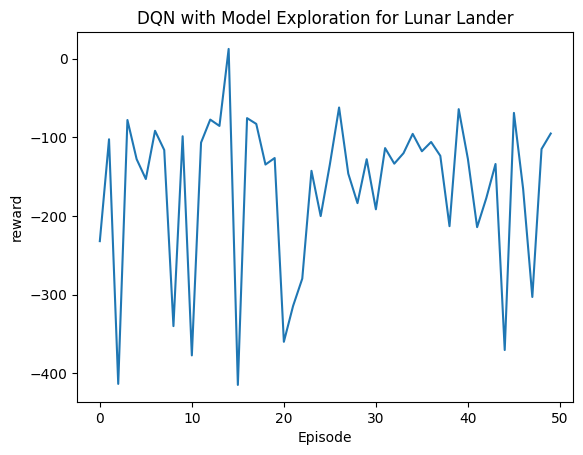

In [ ]:
# Perform DQN with Model Exploration on Lunar Lander Environment

# define/create variables for training
episodes = 50
obs_shape = (1,env_lunar.observation_space.shape[0])
model = Model_Expl_Lunar(env=env_lunar)
tot_rewards = []
ep_steps = []

# define training loop
for episode in range(episodes):
      model.on_episode_start()
      state = env_lunar.reset().reshape(obs_shape)
      step = 0
      tot_reward = 0
      done = False
      while not done:
            # commence training
            step += 1
            action = model.act(state)
            state_next, reward, done, _ = env_lunar.step(action)
            state_next = state_next.reshape(obs_shape)
            model.update_model(state, action, reward, state_next, done)
            cur_state = state_next
            tot_reward += reward
            # end training
            if done:
                break
      model.on_episode_end()

      # record reward
      tot_rewards.append(tot_reward)
      # record steps
      ep_steps.append(step)
      print(f'episode number: {episode}')
      print(f'number of steps: {step}, reward for episode: {tot_reward}')

# draw plot of results
Plot.draw_graph('Lunar Lander', 'DQN with Model Exploration', tot_rewards)